This experiment evaluates the evolution of the error as the number of graphs to be inferred increases. It compares the performance of independently identifying K similar graphs with respect the performance of a joint inference algorithm. 

In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import opt

SEED = 0
PATH = 'results/joint_inf/'
N_CPUS = cpu_count()
np.random.seed(SEED)

### Auxiliary functions

In [16]:
#GL     --> rho1 = 
#GGL    --> rho1 = , rho2  = 
#LVGL   --> rho1 = , beta1 =
#Joint  --> rho1 = , rho2  = , beta1 = , beta2 = 



def plot_err(M, err, ylab, logy=True, ylim=[]):
    plt.figure()
    if logy:
        plt.semilogy(M, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.semilogy(M, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.semilogy(M, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.semilogy(M, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')
    else:
        plt.plot(M, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.plot(M, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.plot(M, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.plot(M, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')

    plt.grid(True)
    plt.xlabel('Number of graphs')
    plt.ylabel(ylab)
    plt.legend()
    plt.xlim([M[0], M[-1]])
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()


def run_exp(id, K, N, O, p, kk, M, pert_links, regs):
    regs_GL = regs['GL']
    regs_GGL = regs['GGL']
    regs_LVGL = regs['LVGL']
    regs_Joint = regs['Joint']
    # Create graphs
    A = np.zeros((N,N))
    tries = 0
    while np.any(np.sum(A,axis=1) == 0) and tries < 100:
        tries += 1
        #A = nx.to_numpy_array(nx.erdos_renyi_graph(N, p))
        A = nx.to_numpy_array(nx.connected_watts_strogatz_graph(N,kk,p))

    assert not np.any(np.sum(A,axis=1) == 0), 'Graphs with nodes with degree 0'

    As = utils.gen_similar_graphs(A, K, pert_links)
    
    # Fix scale
    As = As/np.sum(As[0,1:,0])

    err_mean_norm = np.zeros((len(M), 4))
    err_unit_norm = np.zeros((len(M), 4))
    # Randomly select observed/hidden nodes
    rand_idx = np.random.permutation(np.arange(N))
    idx_o = rand_idx[:O]
    Aos = As[:,idx_o,:][:,:,idx_o]
    for i, m in enumerate(M):
        _, Cs_hat = utils.create_GMRF_data(As, m)
        
        Cos_hat = Cs_hat[:,idx_o,:][:,:,idx_o]

        diag_idx = np.eye(O, dtype=bool)

        Cok_hat = Cos_hat[:K,:,:]
        
        S_ggl = opt.GGL(Cok_hat, regs_GGL)
        S_joint, _ = opt.joint_inf_Apsd(Cok_hat, regs_Joint)

        norm_Ao_sq = 0
        S_lvgl = np.zeros(Cok_hat.shape)
        S_sep_noh = np.zeros(Cok_hat.shape)
        errs_aux = np.zeros(4)
        errs_unit = np.zeros(4)
        for k in range(K):
            norm_Aok = np.linalg.norm(Aos[k,:,:], 'fro')
            norm_Ao_sq += norm_Aok**2

            S_sep_noh[k,:,:] =  opt.GL(Cok_hat[k,:,:], regs_GL)
            S_lvgl[k,:,:], _ = opt.LVGL(Cok_hat[k,:,:], regs_LVGL)

            # Set diags to 0
            S_sep_noh[k,:,:][diag_idx] = 0
            S_ggl[k,:,:][diag_idx] = 0
            S_lvgl[k,:,:][diag_idx] = 0
            S_joint[k,:,:][diag_idx] = 0
            
            # Errs
            errs_aux[0] = np.linalg.norm(S_sep_noh[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[1] = np.linalg.norm(S_ggl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[2] = np.linalg.norm(S_lvgl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[3] = np.linalg.norm(S_joint[k,:,:] - Aos[k,:,:], 'fro')**2
            
            errs_unit[0] = np.linalg.norm(S_sep_noh[k,:,:]/np.linalg.norm(S_sep_noh[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2
            errs_unit[1] = np.linalg.norm(S_ggl[k,:,:]/np.linalg.norm(S_ggl[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2
            errs_unit[2] = np.linalg.norm(S_lvgl[k,:,:]/np.linalg.norm(S_lvgl[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2
            errs_unit[3] = np.linalg.norm(S_joint[k,:,:]/np.linalg.norm(S_joint[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2

        # Compute errors
            err_mean_norm[i,:] += errs_aux/norm_Aok**2/K
            err_unit_norm[i,:] += errs_unit/K


        print('{}-{}: Err LVGL: {:.4f} - Err joint: {:.4f}'.format(id, K, err_mean_norm[i,2], err_mean_norm[i,3]))

    return err_mean_norm, err_unit_norm

In [38]:
# Experiment parameters
#KK = [1, 2, 3, 4,5,6]
K = 4 #3 o 4 
N = 20
O = 18
p = 0.15 #0.2
k = 3
#M = np.array([1,2,3,4,5,6,7,8,9,10])*1e2
MM = [50,100,150,200,250,300,350,400,450]
pert_links = 5
n_graphs = 100
#regs = {'rho1': .0316, 'rho2': 0.01, 'beta1': 1, 'beta2': 0.1}
regs = {'GL':{'rho1': .05}, 
        'GGL':{'rho1': 0.04, 'rho2': 0.01}, #{'rho1': 0.06, 'rho2': 0.02},
        'LVGL': {'rho1': 0.09, 'beta1': 0.8}, #
        'Joint': {'rho1': .07, 'rho2': 0.02, 'beta1': 0.4, 'beta2': 0.1}}
#Joint  --> rho1 = 0.0316, rho2 =0.01, beta1 = 1, beta2 = 0.1

err_mean_norm = np.zeros((len(MM), 4, n_graphs))
err_unit_norm = np.zeros((len(MM), 4, n_graphs))

total_t = time.time()
print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, K, N, O, p, k, MM, pert_links, regs) for i in range(n_graphs))
for i, resp in enumerate(resps):
        err_mean_norm[:,:,i], err_unit_norm[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')


N_CPUS: 64
34-4: Err LVGL: 0.2412 - Err joint: 0.1370
6-4: Err LVGL: 0.2677 - Err joint: 0.2404
8-4: Err LVGL: 0.2162 - Err joint: 0.1573
10-4: Err LVGL: 0.1988 - Err joint: 0.1528
50-4: Err LVGL: 0.3495 - Err joint: 0.3792
14-4: Err LVGL: 0.2638 - Err joint: 0.1996
0-4: Err LVGL: 0.2578 - Err joint: 0.1794
24-4: Err LVGL: 0.3251 - Err joint: 0.2863
40-4: Err LVGL: 0.1879 - Err joint: 0.1593
9-4: Err LVGL: 0.2233 - Err joint: 0.1787
54-4: Err LVGL: 0.3178 - Err joint: 0.2466
11-4: Err LVGL: 0.4525 - Err joint: 0.3258
55-4: Err LVGL: 0.2145 - Err joint: 0.1358
45-4: Err LVGL: 0.3739 - Err joint: 0.3214
39-4: Err LVGL: 0.1812 - Err joint: 0.1775
28-4: Err LVGL: 0.2415 - Err joint: 0.2184
13-4: Err LVGL: 0.2111 - Err joint: 0.1460
27-4: Err LVGL: 0.2854 - Err joint: 0.2161
43-4: Err LVGL: 0.2899 - Err joint: 0.1859
49-4: Err LVGL: 0.2857 - Err joint: 0.2069
18-4: Err LVGL: 0.2279 - Err joint: 0.1767
19-4: Err LVGL: 0.3554 - Err joint: 0.2273
63-4: Err LVGL: 0.1732 - Err joint: 0.1594
4-4:

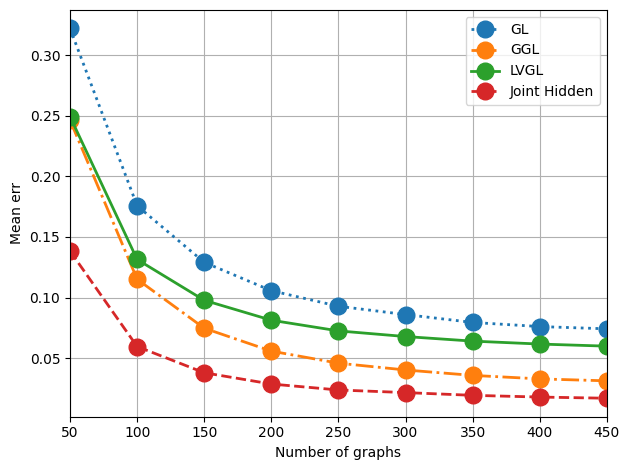

In [39]:
# %matplotlib qt
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_mean_unit_norm = np.mean(err_unit_norm, axis=2)

#plot_err(MM, err_mean_norm_mean, 'Mean err', logy=False)
plot_err(MM, err_mean_unit_norm, 'Mean err', logy=False)

In [50]:
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_mean_unit_norm = np.mean(err_unit_norm, axis=2)

data = {
    'err_mean_norm_mean':err_mean_norm_mean,
    # 'err_mean_norm_mean1': err_mean_unit_norm,
    'err_mean_unit_norm': err_mean_unit_norm,
    'KK': KK
}
np.save('exp_k5_v1',data)

In [13]:
def error_to_csv(fname, models, xaxis, error):
    header = ''
    data = error
    
    if xaxis is not None:
        data = np.concatenate((xaxis.reshape([xaxis.size, 1]), error.T), axis=1)
        header = 'xaxis, '  

    for i, model in enumerate(models):
        header += model
        if i < len(models)-1:
            header += ', '

    np.savetxt(fname, data, delimiter=',', header=header, comments='')
    print('SAVED as:', fname)

In [40]:
error_to_csv('data_exp2_v3',['GL','GGL','LVGL','Joint'],np.array(MM),err_mean_unit_norm.T)

SAVED as: data_exp2_v3


In [192]:
# aux1 = np.load('exp_k5.npy',allow_pickle=True)

In [198]:
# aux2 = aux1.item()['err_mean_norm_mean']